In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 28 22:03:31 2020

@author: nathanl

"""

#import the necessary stuff
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.interpolate import InterpolatedUnivariateSpline
from ripser import ripser
from persim import plot_diagrams
import scipy.io.wavfile
from IPython.display import clear_output
from IPython.display import Audio
from MusicFeatures import *
import librosa
import librosa.display
import os
import pickle
import gc
import persim
import CSMSSMTools
from densityChecked import densityChecked
import time
import sklearn

In [2]:
# This is lazy, but works - imports all the correct stuff based on the feature type
Fs = 44100
def load_all_pds(song_names, split_points, endpoints, feature_type = "novfn", chroma_num =0):
    pds = []
    for song in range(len(song_names)):
        for split_num in range(len(split_points[song])+1):
            song_name = song_names[song]
            if split_num == 0:
                start_point = 0
            else:
                start_point = Fs * split_points[song][split_num-1]
            if split_num == len(split_points[song]):
                end_point = endpoints[song]
            else:
                end_point = Fs * split_points[song][split_num]
            if feature_type == "novfn":
                savepath = "novfn\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)
            if feature_type == "chroma":
                savepath = "chroma_"+chroma_num+"\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)
            with open(savepath, 'rb') as f:
                pds.append(pickle.load(f))
    gc.collect()
    return pds

def load_pds_grouped_by_song(song_names, split_points, endpoints, feature_type = "novfn", chroma_num =0):
    pds_by_song = []
    for song in range(len(song_names)):
        song_pds = []
        for split_num in range(len(split_points[song])+1):
            song_name = song_names[song]
            if split_num == 0:
                start_point = 0
            else:
                start_point = Fs * split_points[song][split_num-1]
            if split_num == len(split_points[song]):
                end_point = endpoints[song]
            else:
                end_point = Fs * split_points[song][split_num]
            if feature_type == "novfn":
                savepath = "novfn\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)
            if feature_type == "chroma":
                savepath = "chroma_"+chroma_num+"\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)
            with open(savepath, 'rb') as f:
                song_pds.append(pickle.load(f))
        pds_by_song.append(song_pds)
        gc.collect()
    return pds_by_song

In [4]:
path = os.path.abspath("Lady Gaga - Shape Features.ipynb")
path = os.path.dirname(path)

# Step 1

famemonster_song_names = ['01 - Bad Romance [Explicit]', '02 - Alejandro', '03 - Monster [Explicit]', 
'04 - Speechless', '05 - Dance In The Dark [Explicit]', '06 - Telephone [feat. Beyoncé]', '07 - So Happy I Could Die', 
'08 - Teeth [Explicit]', "(Disc 2) 01 - Just Dance [feat. Colby O_Donis]", '(Disc 2) 02 - LoveGame', 
'(Disc 2) 04 - Poker Face', '(Disc 2) 07 - The Fame', '(Disc 2) 09 - Starstruck [feat. Space Cowboy _ Flo Rida]',
'(Disc 2) 11 - Paper Gangsta [Explicit]', '(Disc 2) 12 - Brown Eyes', '(Disc 2) 13 - I Like It Rough',
'(Disc 2) 14 - Summerboy', '(Disc 2) 15 - Disco Heaven']

famemonster_filepaths = []

for i in range(len(famemonster_song_names)):
    famemonster_filepaths.append(path + '\\..\\FameMonster\\' + famemonster_song_names[i] + ".wav") 

# Missing Do What U Want for some reason
artpop_song_names = ['01 - Aura [Explicit]', '02 - Venus [Explicit]', '03 - G.U.Y. [Explicit]', '04 - Sexxx Dreams [Explicit]', 
'05 - Jewels N_ Drugs [feat. T.I. _ Too $hort _ Twista] [Explicit]', '06 - MANiCURE', '07 - ARTPOP',
'08 - Swine [Explicit]', '09 - Donatella [Explicit]', '10 - Fashion!', '11 - Mary Jane Holland [Explicit]',
'12 - Dope [Explicit]', '13 - Gypsy', '14 - Applause']

artpop_filepaths = []

for i in range(len(artpop_song_names)):
    artpop_filepaths.append(path + '\\..\\Artpop\\' + artpop_song_names[i] + ".wav") 
    
chromatica_song_names = ['01 Chromatica I', '02 Alice', '03 Stupid Love', '04 Rain On Me', '05 Free Woman',
'06 Fun Tonight', '07 Chromatica II', '08 911', '09 Plastic Doll', '10 Sour Candy', '11 Enigma', '12 Replay',
'13 Chromatica III', '14 Sine From Above', '15 1000 Doves', '16 Babylon']

chromatica_filepaths = []

for i in range(len(chromatica_song_names)):
    chromatica_filepaths.append(path + '\\..\\Chromatica\\' + chromatica_song_names[i] + ".wav") 

    
famemonster_song_splits = [
    # 1 - Bad Romance
    [18, 26, 34, 66, 74, 106, 115, 147, 155, 187, 203, 220, 235, 250, 284, 292],
    # 2 - Alejandro
    [15, 26, 35, 44, 64, 73, 113, 123, 142, 152, 190, 210, 229, 248, 268],
    # 3 - Monster
    [10, 17, 25, 33, 49, 66, 81, 84, 97, 114, 129, 145, 148, 162, 177, 193, 202, 212, 229, 245],
    # 4 - Speechless
    [15, 42, 55, 82, 123, 149, 174, 196, 204, 230, 263, 267],
    # 5 Dance in the Dark
    [18, 33, 49, 77, 79, 110, 136, 156, 205, 220, 227, 239, 258, 273, 285],
    # 6 Telephone
    [9, 25, 33, 49, 64, 80, 96, 112, 120, 127, 135, 167, 182, 199, 214],
    # 7 So Happy I could Die
    [20, 39, 59, 78, 97, 117, 136, 145, 155, 164, 174, 193, 204, 231],
    # 8 Teeth
    [11, 22, 61, 82, 121, 140, 152, 172, 191, 201],
    # 1 Just Dance
    [6, 9, 17, 33, 50, 68, 84, 100, 116, 133, 148, 156, 174, 180, 197, 212, 221, 237],
    # 2 Love Game
    [10, 17, 37, 46, 55, 73, 81, 101, 110, 119, 137, 146, 165, 173, 197],
    # 4 Poker Face
    [9, 18, 26, 33, 41, 58, 74, 82, 90, 98, 114, 130, 138, 146, 155, 163, 171, 211],
    # 7 The Fame
    [4, 11, 19, 34, 49, 64, 79, 110, 125, 140, 155, 163, 170, 201],
    # 9 Starstruck
    [20, 38, 58, 76, 94, 132, 150, 169, 187, 211],
    # 11 Paper Gangsta
    [11, 20, 40, 47, 67, 87, 106, 115, 135, 145, 182, 193, 223, 252],
    # 12 Brown Eyes
    [8, 25, 55, 82, 130, 157, 173, 202, 220, 237],
    # 13 I like it Rough
    [9, 25, 41, 57, 73, 89, 104, 120, 138, 153, 184],
    # 14 Summerboy
    [13, 31, 49, 67, 77, 113, 136, 172, 218],
    # 15 Disco Heaven
    [15, 45, 75, 105, 135, 166, 197, 212]
    
]    
# An array of arrays, where subarray corresponds to splits for a given song
artpop_song_splits = [
    # 1 - Aura
    [9, 34, 56, 67, 72, 100, 137, 152, 167, 182, 215, 219],
    # 2- Venus
    [7, 40, 56, 72, 88, 104, 120, 134, 152, 167, 199, 215],
    # 3 GUY
    [18, 27, 45, 53, 62, 80, 88, 105, 121, 140, 158, 186, 220, 230],
    # 4 Sexxx Dreams
    [5, 34, 51, 56, 72, 106, 118, 140, 159, 177, 211],
    # 5 Jewels N Drugs
    [6, 20, 51, 65, 93, 107, 136, 163, 217],
    # 6 Manicure
    [16, 29, 43, 57, 85, 112, 120, 134, 148, 168],
    # 7 Artpop
    [18, 50, 85, 90, 122, 155, 172, 204, 237],
    # 8 Swine
    [9, 38, 67, 97, 127, 157, 187, 202, 217, 232, 247],
    # 9 Donatella
    [4, 8, 19, 50, 65, 81, 97, 141, 157, 172, 187, 203, 218, 249],
    # 10 Fashion
    [17, 35, 68, 100, 126, 149, 168, 184, 200],
    # 11 Mary Jane Holland
    [10, 48, 67, 86, 105, 123, 142, 161, 210, 248, 268, 275],
    # 12 Dope
    [16, 93,  108, 153, 186, 197],
    # 13 Gypsy
    [30, 45, 58, 73, 102, 116, 130, 144, 161, 171, 194, 202, 216, 231, 244],
    # 14 - Applause
    [15,56,70,83,109,143,151,164,178, 208]
]

chromatica_song_splits = [
    # Chromatica I
    [],
    # Alice
    [18, 34, 50, 65, 96, 112, 129, 143],
    # Stupid Love
    [9, 26, 41, 57, 74, 90, 108, 122, 140, 156],
    # Rain on Me
    [16, 32, 41, 46, 64, 80, 95, 109, 127, 143, 148, 166, 173],
    # Free Woman
    [9, 41, 58, 73, 91, 122, 138, 155, 170, 186],
    # Fun Tonight
    [4, 20, 36, 52, 68, 87, 102, 118, 134, 152, 172],
    # Chromatica II
    [31],
    # 911
    [9, 26, 35, 41, 59, 75, 84, 92, 108, 117, 131, 150, 167],
    # Plastic Doll
    [9, 17, 49, 63, 81, 96, 112, 144, 152, 160, 169, 202, 217],
    # Sour Candy
    [8, 10, 17, 33, 64, 81, 90, 110, 125, 142, 150],
    # Enigma
    [5, 22, 34, 48, 66, 83, 94, 112, 128, 140, 145, 174],
    # Replay
    [13, 21, 39, 55, 71, 88, 104, 122, 136, 151, 183],
    # Chromatica III
    [],
    # Sine from above
    [9, 40, 56, 71, 85, 87, 103, 119, 133, 149, 165, 178, 180, 195, 203, 209, 215, 221, 241],
    # 1000 Doves
    [17, 34, 48, 64, 80, 96, 111, 127, 143, 166, 182, 213],
    # Babylon
    [6, 10, 26, 32, 42, 50, 65, 67, 83, 89, 91, 106, 110, 124, 141, 155, 158]
]


In [5]:
# Loads in all the persistence diagrams from the files

famemonster_pds = []
artpop_pds = []
chromatica_pds = []

with open("famemonster_endpoints", 'rb') as f:
    famemonster_endpoints = pickle.load(f)

famemonster_pds = load_all_pds(famemonster_song_names, famemonster_song_splits, famemonster_endpoints)
famemonster_pds_by_song = load_pds_grouped_by_song(famemonster_song_names, famemonster_song_splits, famemonster_endpoints)

with open("artpop_endpoints", 'rb') as f:
    artpop_endpoints = pickle.load(f)

artpop_pds = load_all_pds(artpop_song_names, artpop_song_splits, artpop_endpoints)
artpop_pds_by_song = load_pds_grouped_by_song(artpop_song_names,artpop_song_splits, artpop_endpoints)

with open("chromatica_endpoints", 'rb') as f:
    chromatica_endpoints = pickle.load(f)

chromatica_pds = load_all_pds(chromatica_song_names, chromatica_song_splits, chromatica_endpoints)
chromatica_pds_by_song = load_pds_grouped_by_song(chromatica_song_names, chromatica_song_splits, chromatica_endpoints)


In [6]:
'''
pds_by_song is an array containing one array for each song. The array for each song contains 
arrays of size two corresponding to the zeroth and first homologies respectively. 

segment_indices_by_song is an array containing one array for each song. The array for each song
contains arrays corresponding to the indices of whatever segment type you want (chorus, verse, etc)
for that song
'''
def get_pds_by_indices(pds_by_song, segment_indices_by_song):
    pds_at_indices = []
    for song_index in range(len(pds_by_song)):
        sliced_pds_by_song = []
        for segment_index in segment_indices_by_song[song_index]:
#            if(len(pds_by_song[song_index]) == 0):
#                print(pds_by_song[song_index])
            pds = pds_by_song[song_index][segment_index]
            sliced_pds_by_song.append(pds)
        pds_at_indices.append(sliced_pds_by_song)
    return pds_at_indices

In [10]:
print(len(famemonster_pds[0]))

2


PersImage(pixels=[40, 40], spread=0.25, specs=None, kernel_type="gaussian", weighting_type="linear")


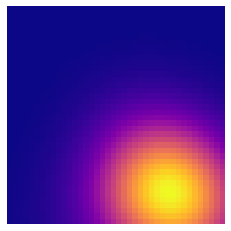

In [40]:
pim = persim.PersImage(pixels = [20,20], spread = 0.25)
imgs = pim.transform(famemonster_pds[4][1])
pim.show(imgs)


In [41]:
# Feed in only 1-dim persistence diagrams, let diagrams_arr just be a simple 1d array
def compute_and_store_images(diagrams_arr, savepath):
    pim = persim.PersImage(pixels = [20,20], spread = 0.25)
    imgs = pim.transform(diagrams_arr)
    outfile = open(savepath, "wb")
    pickle.dump(imgs, outfile)
    outfile.close()
    
def compute_and_store_images_by_song(diagrams_arr_by_song, savepath):
    pim = persim.PersImage(pixels = [20,20], spread = 0.25)
    imgs = pim.transform(diagrams_arr)
    outfile = open(savepath, "wb")
    pickle.dump(imgs, outfile)
    outfile.close()

# Takes in an array of (song) arrays with (segment) pairs of h0 and h1
def get_h1_persistences(pds_by_song):
    h1_persistences = []
    for song in pds_by_song:
        for segment in song:
            h1_persistences.append(segment[1])
    return h1_persistences

def load_images(savepath):
    with open(savepath, 'rb') as f:
        return pickle.load(f)

In [52]:
#compute_and_store_images(get_h1_persistences(chromatica_pds_by_song), 'chromatica_imgs')


PersImage(pixels=[20, 20], spread=0.25, specs=None, kernel_type="gaussian", weighting_type="linear")


In [53]:
famemonster_imgs = load_images('famemonster_imgs')
artpop_imgs = load_images('artpop_imgs')
chromatica_imgs = load_images('chromatica_imgs')

In [67]:
labels = np.concatenate([np.full((1,len(famemonster_imgs)), 1), np.full((1,len(artpop_imgs)), 2), np.full((1,len(chromatica_imgs)), 3)], axis = 1)[0]
print(labels)
print(len(labels))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 

607


In [70]:
from sklearn.model_selection import train_test_split
all_imgs = np.concatenate([famemonster_imgs, artpop_imgs, chromatica_imgs])
all_imgs_array = np.array([img.flatten() for img in all_imgs])

X_train, X_test, y_train, y_test = train_test_split(all_imgs_array, labels, test_size=0.40, random_state=412)


In [92]:
from sklearn.linear_model import LogisticRegression

C_vals = [10**-2, 10**-1, 1, 10, 100,1000]

for C in C_vals:    
    lr = LogisticRegression(C=C,class_weight = 'balanced', multi_class = 'ovr', max_iter = 1000)
    lr.fit(X_train, y_train)
    print(lr.score(X_test, y_test))

0.43209876543209874
0.42386831275720166
0.4691358024691358
0.51440329218107
0.5720164609053497
0.5967078189300411


In [95]:
from sklearn.model_selection import cross_val_score


C_vals = [10**-2, 10**-1, 1, 10, 100,1000]

for C in C_vals:    
    lr = LogisticRegression(C=C,class_weight = 'balanced', multi_class = 'ovr', max_iter = 1000)
    print(cross_val_score(lr, X_train, y_train, cv=5))
lr = LogisticRegression(C=1000,class_weight = 'balanced', multi_class = 'ovr', max_iter = 1000)
lr.fit(X_train, y_train)
lr.score(X_test,y_test)

[0.46575342 0.43835616 0.47945205 0.57534247 0.375     ]
[0.46575342 0.46575342 0.49315068 0.61643836 0.36111111]
[0.42465753 0.49315068 0.47945205 0.61643836 0.34722222]
[0.47945205 0.56164384 0.52054795 0.57534247 0.41666667]
[0.56164384 0.65753425 0.68493151 0.63013699 0.43055556]
[0.57534247 0.71232877 0.75342466 0.67123288 0.5       ]


0.5967078189300411

In [117]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

train_scores = []
val_scores = []
test_scores = []
for C in C_vals:    
    clf = make_pipeline(StandardScaler(), SVC(C=C, gamma = 'auto', class_weight = 'balanced'))
    val_scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(C)
    print(val_scores)
    print(val_scores.mean())
    val_scores = np.append(val_scores, val_scores.mean())
    clf.fit(X_train, y_train)
    train_scores = np.append(train_scores, clf.score(X_train,y_train))
    test_scores = np.append(test_scores, clf.score(X_test,y_test))
    print(clf.score(X_test,y_test))

0.01
[0.28767123 0.28767123 0.39726027 0.49315068 0.27777778]
0.3487062404870624
0.43209876543209874
0.1
[0.45205479 0.50684932 0.4109589  0.52054795 0.375     ]
0.45308219178082193
0.49794238683127573
1
[0.54794521 0.53424658 0.46575342 0.69863014 0.47222222]
0.5437595129375952
0.5349794238683128
10
[0.57534247 0.60273973 0.54794521 0.68493151 0.54166667]
0.5905251141552511
0.6213991769547325
100
[0.60273973 0.73972603 0.64383562 0.63013699 0.58333333]
0.6399543378995434
0.5967078189300411
1000
[0.67123288 0.69863014 0.65753425 0.65753425 0.56944444]
0.650875190258752
0.6172839506172839


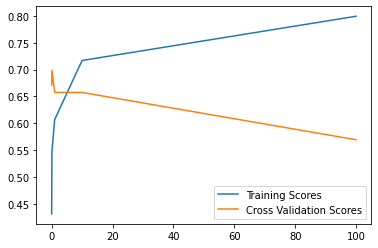

In [115]:

plt.plot(C_vals[:-1], train_scores[:-1], label = "Training Scores")
plt.plot(C_vals[:-1], val_scores[:-1], label = "Cross Validation Scores")
plt.legend()
plt.show()

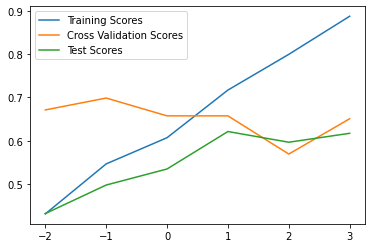

In [113]:

plt.plot(np.log10(C_vals), train_scores, label = "Training Scores")
plt.plot(np.log10(C_vals), val_scores, label = "Cross Validation Scores")
plt.plot(np.log10(C_vals), test_scores, label = "Test Scores")
plt.legend()
plt.show()

In [93]:
unique, counts = np.unique(lr.predict(X_test), return_counts=True)
dict(zip(unique, counts))

{1: 103, 2: 70, 3: 70}